In [0]:
%pip install hyperopt

Note: you may need to restart the kernel using %restart_python or dbutils.library.restartPython() to use updated packages.


In [0]:
%pip install xgboost


Note: you may need to restart the kernel using %restart_python or dbutils.library.restartPython() to use updated packages.


In [0]:
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from xgboost import XGBRegressor
from hyperopt import Trials, fmin, tpe, STATUS_OK
import numpy as np
import matplotlib.pyplot as plt


In [0]:
from pyspark.sql.functions import to_timestamp

 #Load & Preview Data
train_df = spark.read.csv('/FileStore/tables/train.csv/train.csv', header=True, inferSchema=True)
test_df  = spark.read.csv('/FileStore/tables/test.csv/test.csv', header=True, inferSchema=True)

# to_timestamp definition
train_df = train_df.withColumn('Date', to_timestamp('Date'))
test_df  = test_df.withColumn('Date', to_timestamp('Date'))

display(train_df.limit(5))
train_df.printSchema()


Date,store,product,number_sold
2010-01-01T00:00:00.000Z,0,0,801
2010-01-02T00:00:00.000Z,0,0,810
2010-01-03T00:00:00.000Z,0,0,818
2010-01-04T00:00:00.000Z,0,0,796
2010-01-05T00:00:00.000Z,0,0,808


root
 |-- Date: timestamp (nullable = true)
 |-- store: integer (nullable = true)
 |-- product: integer (nullable = true)
 |-- number_sold: integer (nullable = true)



In [0]:
# Hybrid Time Series Forecasting

try:
    from xgboost import XGBRegressor
    print("Using XGBRegressor from xgboost")
except ImportError:
    from sklearn.ensemble import GradientBoostingRegressor as XGBRegressor
    print("XGBoost not found; using GradientBoostingRegressor as fallback")

from pyspark.sql import functions as F
from pyspark.sql.functions import array, dayofweek, month, year, to_timestamp
from pyspark.ml.linalg import Vectors, VectorUDT

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import GridSearchCV, cross_val_score, TimeSeriesSplit

from hyperopt import hp, tpe, fmin, STATUS_OK, Trials

# Spark ML feature vector
to_vector = F.udf(lambda arr: Vectors.dense(arr), VectorUDT())

# constants
DEBUG_MODE      = False  
total_series = 70
SAMPLE_SERIES   = max(1, int(total_series * 0.05))  

FEATURE_COLS    = ["store","product","dayOfWeek","month","year"]
GRID_PARAMS     = {'n_estimators':[50,100], 'max_depth':[5,10], 'learning_rate':[0.05,0.1]}
HPO_SPACE       = {
    'n_estimators': hp.choice('n_estimators',[50,100]),
    'max_depth':    hp.choice('max_depth',[5,10]),
    'learning_rate':hp.choice('learning_rate',[0.05,0.1])
}
TS_CV           = TimeSeriesSplit(n_splits=3)


Using XGBRegressor from xgboost


Date,store,product,number_sold
0,0,0,0


summary,store,product,number_sold
count,230090,230090,230090
mean,3.0,4.5,780.9261071754531
stddev,2.0000043461395958,2.872287564936809,204.09673676252913
min,0,0,238
max,6,9,1205


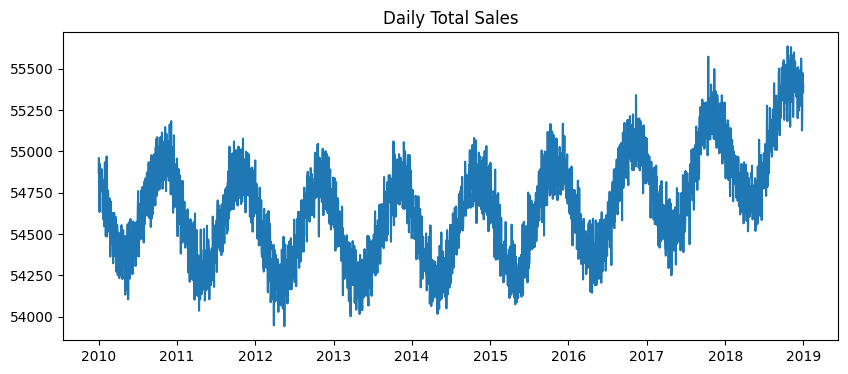

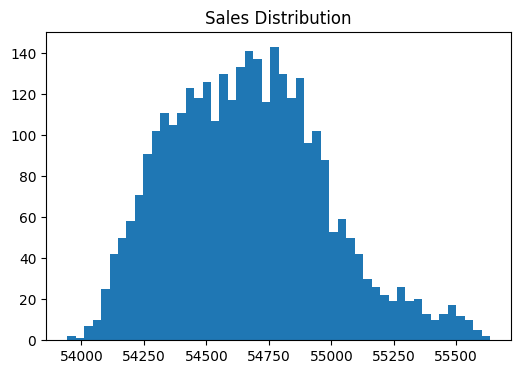

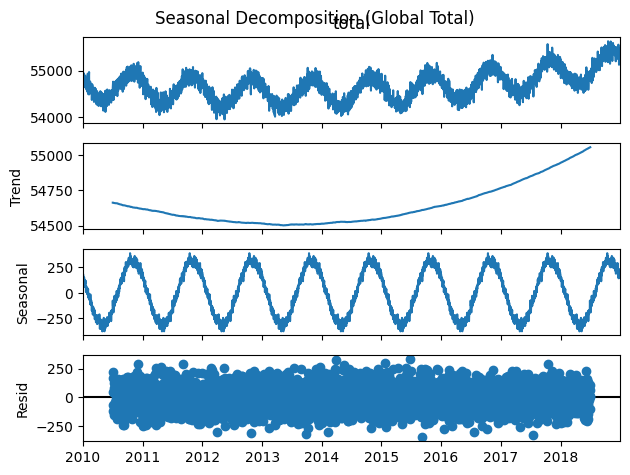

ADF Statistic: -2.532, p-value: 0.108


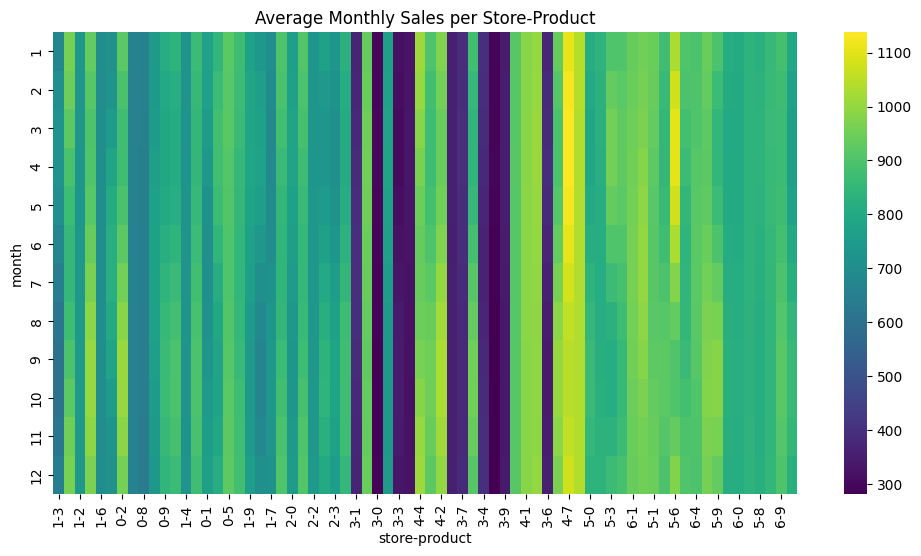

store,product,mean,std,min,max
0,0,828.6769090355948,38.40298254021581,747,921
0,1,738.3793732887132,37.13892066734181,641,884
0,2,940.4794645573471,51.137524065766804,814,1055
0,3,851.4937633100092,37.26923977162889,750,938
0,4,907.4292668086401,44.673241545748624,808,1020
0,5,912.763614237907,19.662747884538835,841,976
0,6,871.7052023121387,21.484621607652215,809,938
0,7,951.7058107696988,46.03519029933537,815,1066
0,8,644.7295406145421,36.34185661439008,546,773
0,9,827.8509278977791,32.285817275712034,735,913


In [0]:
#EDA

# Missing Values & Descriptive Stats

missing = train_df.select([F.count(F.when(F.col(c).isNull(),c)).alias(c) for c in train_df.columns])
display(missing)
display(train_df.describe())

# Trend & Distribution

ts = train_df.groupBy('Date').sum('number_sold')\
    .withColumnRenamed('sum(number_sold)','total')\
    .orderBy('Date')\
    .toPandas()
plt.figure(figsize=(10,4))
plt.plot(ts['Date'], ts['total'])
plt.title('Daily Total Sales')
plt.show()
plt.figure(figsize=(6,4))
plt.hist(ts['total'], bins=50)
plt.title('Sales Distribution')
plt.show()

# Decomposition & Stationarity

decomp = seasonal_decompose(ts.set_index('Date')['total'], model='additive', period=365)
decomp.plot(); plt.suptitle('Seasonal Decomposition (Global Total)'); plt.show()
adf_stat, p_value, *_ = adfuller(ts['total'])
print(f"ADF Statistic: {adf_stat:.3f}, p-value: {p_value:.3f}")

# Seasonality Heatmap

avg = train_df.withColumn('month', month('Date'))\
    .groupBy('store','product','month')\
    .avg('number_sold')\
    .withColumnRenamed('avg(number_sold)','avg_sold')\
    .toPandas()
pivot = avg.pivot(index='month', columns=['store','product'], values='avg_sold')
plt.figure(figsize=(12,6))
sns.heatmap(pivot, cmap='viridis')
plt.title('Average Monthly Sales per Store-Product')
plt.show()

# Store-Product Stats

stats = train_df.groupBy('store','product')\
    .agg(
        F.avg('number_sold').alias('mean'),
        F.stddev('number_sold').alias('std'),
        F.min('number_sold').alias('min'),
        F.max('number_sold').alias('max')
    )
stats_pd = stats.toPandas().sort_values(['store','product']).head(20)
display(stats_pd)


In [0]:
# Feature Engineering

train_feat = train_df\
    .withColumn('dayOfWeek', dayofweek('Date'))\
    .withColumn('month', month('Date'))\
    .withColumn('year', year('Date'))\
    .withColumn('dayOfYear', F.dayofyear('Date'))\
    .withColumn('weekOfYear', F.weekofyear('Date'))\
    .withColumn('is_month_start', (F.dayofmonth('Date')==1).cast('integer'))\
    .withColumn('is_month_end', (F.dayofmonth('Date')==F.dayofmonth(F.last_day('Date'))).cast('integer'))
all_feats = FEATURE_COLS + ['dayOfYear','weekOfYear','is_month_start','is_month_end']
train_prepped = train_feat\
    .withColumn('feat_array', array(*all_feats))\
    .withColumn('features', to_vector('feat_array'))\
    .drop('feat_array')

display(train_prepped.select('features','number_sold').limit(5))


features,number_sold
"{""type"":""1"",""size"":null,""indices"":null,""values"":[""0.0"",""0.0"",""6.0"",""1.0"",""2010.0"",""1.0"",""53.0"",""1.0"",""0.0""]}",801
"{""type"":""1"",""size"":null,""indices"":null,""values"":[""0.0"",""0.0"",""7.0"",""1.0"",""2010.0"",""2.0"",""53.0"",""0.0"",""0.0""]}",810
"{""type"":""1"",""size"":null,""indices"":null,""values"":[""0.0"",""0.0"",""1.0"",""1.0"",""2010.0"",""3.0"",""53.0"",""0.0"",""0.0""]}",818
"{""type"":""1"",""size"":null,""indices"":null,""values"":[""0.0"",""0.0"",""2.0"",""1.0"",""2010.0"",""4.0"",""1.0"",""0.0"",""0.0""]}",796
"{""type"":""1"",""size"":null,""indices"":null,""values"":[""0.0"",""0.0"",""3.0"",""1.0"",""2010.0"",""5.0"",""1.0"",""0.0"",""0.0""]}",808


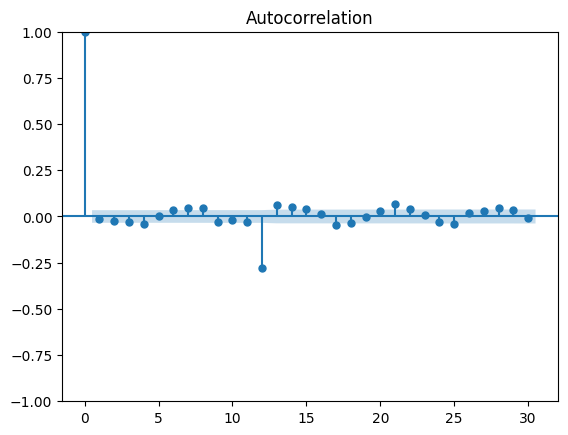

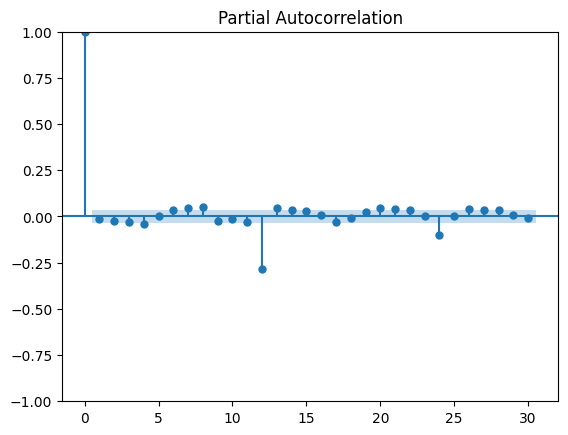

/databricks/python/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/databricks/python/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/databricks/python/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/databricks/python/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/databrick

In [0]:
# ARIMA Baseline per Series

DEBUG_MODE     = False  
SAMPLE_SERIES  = max(1, int(total_series * 0.05))

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
import matplotlib.pyplot as plt

#  store, produc pairs
pairs = train_df.select('store','product').distinct().collect()

if DEBUG_MODE:
    pairs = pairs[:SAMPLE_SERIES]

baseline_list = []
for idx, r in enumerate(pairs):
    s, p = r['store'], r['product']
   
    pdf = (
        train_df
          .filter((F.col('store')==s) & (F.col('product')==p))
          .select('Date','number_sold')
          .orderBy('Date')
          .toPandas()
    )
   
    pdf['Date'] = pd.to_datetime(pdf['Date'])
    pdf = pdf.set_index('Date').asfreq('D')     # <— sets freq='D'
    
    # fit SARIMAX with explicit freq
    model = SARIMAX(
        pdf['number_sold'],
        order=(1,1,1),
        seasonal_order=(1,1,1,12),
        freq='D'       # SARIMAX the index frequency
    )
    res = model.fit(disp=False)
    
    #  residual ACF/PACF for first series only
    if idx == 0:
        plot_acf(res.resid, lags=30)
        plt.show()
        plot_pacf(res.resid, lags=30)
        plt.show()
    
    #  baseline predictions
    pred = res.get_prediction(start=pdf.index[0], end=pdf.index[-1])
    dfp  = (
        pred.predicted_mean
            .reset_index()
            .rename(columns={'predicted_mean':'baseline','index':'Date'})
    )
    dfp['store'], dfp['product'] = s, p
    baseline_list.append(dfp)

baseline_df = pd.concat(baseline_list, ignore_index=True)


In [0]:
# Hybrid Dataset after - ARIMA baseline loop


df_feat = train_prepped.select(
    'Date','store','product','features','number_sold'
).toPandas()

ALL_FEATS = FEATURE_COLS + ['dayOfYear','weekOfYear','is_month_start','is_month_end']
feat_expanded = pd.DataFrame(
    df_feat['features'].tolist(),
    columns=ALL_FEATS
)

feat_expanded = feat_expanded.drop(columns=['store','product'])

base_df = pd.concat([
    df_feat[['Date','store','product','number_sold']].reset_index(drop=True),
    feat_expanded
], axis=1)

#  Merge in the ARIMA baseline
base_df['Date']     = pd.to_datetime(base_df['Date'])
baseline_df['Date'] = pd.to_datetime(baseline_df['Date'])

hybrid_df = base_df.merge(
    baseline_df[['Date','store','product','baseline']],
    on=['Date','store','product'],
    how='left'
)

# build X, y, base
X_cols = FEATURE_COLS + ['dayOfYear','weekOfYear','is_month_start','is_month_end']
X     = hybrid_df[X_cols].values
y     = hybrid_df['number_sold'].values
base  = hybrid_df['baseline'].fillna(0).values

# sanity check
print("hybrid_df shape:", hybrid_df.shape)
print("X shape:", X.shape, "y shape:", y.shape, "base shape:", base.shape)


hybrid_df shape: (230090, 12)
X shape: (230090, 9) y shape: (230090,) base shape: (230090,)


In [0]:
# engineered extra
ENGINEERED = ['dayOfYear','weekOfYear','is_month_start','is_month_end']

# expand
feat_expanded = pd.DataFrame(
    df_feat['features'].tolist(),
    columns=FEATURE_COLS + ENGINEERED
)

# drop the originals from the expansion
feat_expanded = feat_expanded.drop(columns=FEATURE_COLS)

base_df = pd.concat([
    df_feat[['Date','store','product','number_sold']].reset_index(drop=True),
    feat_expanded
], axis=1)


100%|██████████| 10/10 [00:50<00:00,  5.08s/trial, best loss: 224.16217879866156]
GridSearch MAE: 224.162, Params: {'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 50}
HyperOpt   MAE: 224.162, Params: {'n_estimators': 50, 'max_depth': 5, 'learning_rate': 0.05}


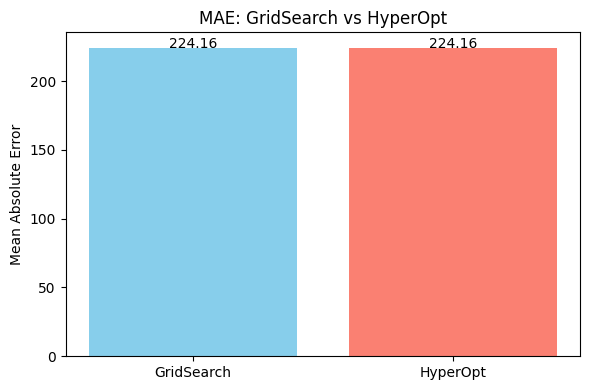

In [0]:
# Hyperparameter Tuning & Comparison

from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from xgboost import XGBRegressor
from hyperopt import fmin, tpe, Trials, STATUS_OK
import numpy as np
import matplotlib.pyplot as plt

TS_CV     = TimeSeriesSplit(n_splits=3)
GRID_PARAMS = { 'n_estimators':[50,100], 'max_depth':[5,10], 'learning_rate':[0.05,0.1] }
HPO_SPACE   = {
    'n_estimators': hp.choice('n_estimators',[50,100]),
    'max_depth':    hp.choice('max_depth',[5,10]),
    'learning_rate':hp.choice('learning_rate',[0.05,0.1])
}

# Grid Search 

grid_search = GridSearchCV(
    XGBRegressor(random_state=42, verbosity=0),
    GRID_PARAMS,
    cv=TS_CV,
    scoring='neg_mean_absolute_error'
)
grid_search.fit(X, y)
gs_mae   = -grid_search.best_score_
gs_params= grid_search.best_params_

# HyperOpt

def objective(params):
    model = XGBRegressor(
        n_estimators=int(params['n_estimators']),
        max_depth=int(params['max_depth']),
        learning_rate=params['learning_rate'],
        random_state=42, verbosity=0
    )
    loss = -cross_val_score(model, X, y, cv=TS_CV,
                            scoring='neg_mean_absolute_error').mean()
    return {'loss': loss, 'status': STATUS_OK}

trials  = Trials()
best_ho = fmin(objective, HPO_SPACE, algo=tpe.suggest,
               max_evals=10, trials=trials,
               rstate=np.random.default_rng(42))

ho_mae = min(t['result']['loss'] for t in trials.trials)
ho_params = {
    'n_estimators':   [50,100][best_ho['n_estimators']],
    'max_depth':      [5,10][best_ho['max_depth']],
    'learning_rate':  [0.05,0.1][best_ho['learning_rate']]
}

print(f"GridSearch MAE: {gs_mae:.3f}, Params: {gs_params}")
print(f"HyperOpt   MAE: {ho_mae:.3f}, Params: {ho_params}")

# Visual 

methods, mae_scores = ['GridSearch','HyperOpt'], [gs_mae, ho_mae]
plt.figure(figsize=(6,4))
plt.bar(methods, mae_scores, color=['skyblue','salmon'])
plt.title('MAE: GridSearch vs HyperOpt')
plt.ylabel('Mean Absolute Error')
for i,v in enumerate(mae_scores):
    plt.text(i, v + 0.1, f"{v:.2f}", ha='center')
plt.tight_layout()
plt.show()


In [0]:
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
import joblib

# XGBoost best params from GridSearch/HyperOpt
gs_params = {
    'n_estimators':   50,
    'max_depth':      5,
    'learning_rate':  0.05
}

# RandomForest 
rf_best_params = {
    'n_estimators': 100,
    'max_depth':    None
}

xgb_final = XGBRegressor(**gs_params, random_state=42, verbosity=0)
rf_final  = RandomForestRegressor(**rf_best_params, random_state=42)

xgb_final.fit(X, y)
rf_final.fit(X, y)

y_pred_xgb = base + xgb_final.predict(X)
y_pred_rf  = base + rf_final.predict(X)

# Evaluate
print("FULL-DATA MAE  (XGB hybrid):", mean_absolute_error(y, y_pred_xgb))
print("FULL-DATA RMSE (XGB hybrid):", mean_squared_error(y, y_pred_xgb, squared=False))
print("FULL-DATA MAE  (RF  hybrid):", mean_absolute_error(y, y_pred_rf))
print("FULL-DATA RMSE (RF  hybrid):", mean_squared_error(y, y_pred_rf, squared=False))




FULL‐DATA MAE  (XGB hybrid): 780.7434579357887
FULL‐DATA RMSE (XGB hybrid): 801.7393892702466
FULL‐DATA MAE  (RF  hybrid): 780.7359765180001
FULL‐DATA RMSE (RF  hybrid): 807.0669556877405


In [0]:
import pandas as pd
import numpy as np
import joblib
from statsmodels.tsa.statespace.sarimax import SARIMAX

def make_features(df):
    df = df.copy()
    df['dayOfWeek']     = df['Date'].dt.dayofweek + 1
    df['month']         = df['Date'].dt.month
    df['year']          = df['Date'].dt.year
    df['dayOfYear']     = df['Date'].dt.dayofyear
    df['weekOfYear']    = df['Date'].dt.isocalendar().week
    df['is_month_start']= (df['Date'].dt.day == 1).astype(int)
    df['is_month_end']  = (df['Date'].dt.is_month_end).astype(int)
    return df

def compute_arima_baseline(df):
    out = []
    for (s,p), grp in df.groupby(['store','product']):
        ts = grp.set_index('Date')['number_sold'].asfreq('D')
        m  = SARIMAX(ts, order=(1,1,1), seasonal_order=(1,1,1,12), freq='D').fit(disp=False)
        # forecast next day
        next_d = ts.index[-1] + pd.Timedelta(days=1)
        pred   = m.forecast(steps=1).iloc[0]
        out.append({'store':s, 'product':p, 'Date':next_d, 'baseline':float(pred)})
    return pd.DataFrame(out)

def generate_forecasts(input_csv, output_csv, model_path="xgb_hybrid_model.joblib"):
    # Load data
    df = pd.read_csv(input_csv, parse_dates=['Date'])
    # Make features
    df_feat = make_features(df)
    # Compute ARIMA baseline
    baseline_df = compute_arima_baseline(df_feat)
    #  Take the last row per series
    last = df_feat.sort_values(['store','product','Date'])\
                  .groupby(['store','product']).tail(1).reset_index(drop=True)
    score = last.merge(baseline_df, on=['store','product','Date'], how='left')
    #  Load your XGB model
    xgb = joblib.load(model_path)
    #  Build X matrix
    FEATURES = [
      'store','product','dayOfWeek','month','year',
      'dayOfYear','weekOfYear','is_month_start','is_month_end'
    ]
    X_score = score[FEATURES].values
    #  Predict + add baseline
    score['predicted'] = score['baseline'] + xgb.predict(X_score)
    
    score[['Date','store','product','predicted']].to_csv(output_csv, index=False)
    print(f"✅ Forecasts saved to {output_csv}")


In [0]:
display(dbutils.fs.ls("dbfs:/FileStore/tables/train.csv"))


path,name,size,modificationTime
dbfs:/FileStore/tables/train.csv/train-1.csv,train-1.csv,4387800,1751408094000
dbfs:/FileStore/tables/train.csv/train.csv,train.csv,4387800,1751373777000


Model,MAE,RMSE
ARIMA+GridSearch XGB,780.7434579357887,801.7393892702466
ARIMA+RF,780.7359765180001,807.0669556877405
ARIMA+XGB,780.7357393826853,806.9722159656964
ARIMA+MLP,10.785207245926921,20.037360445902642


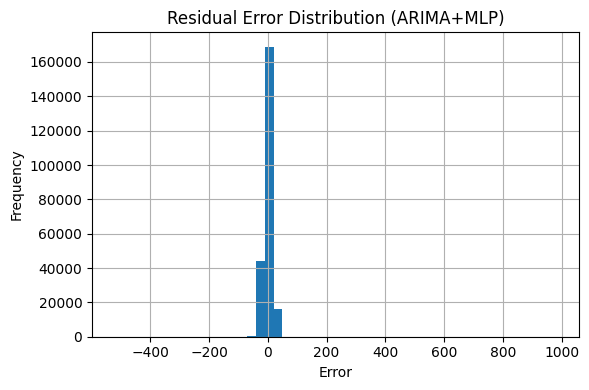

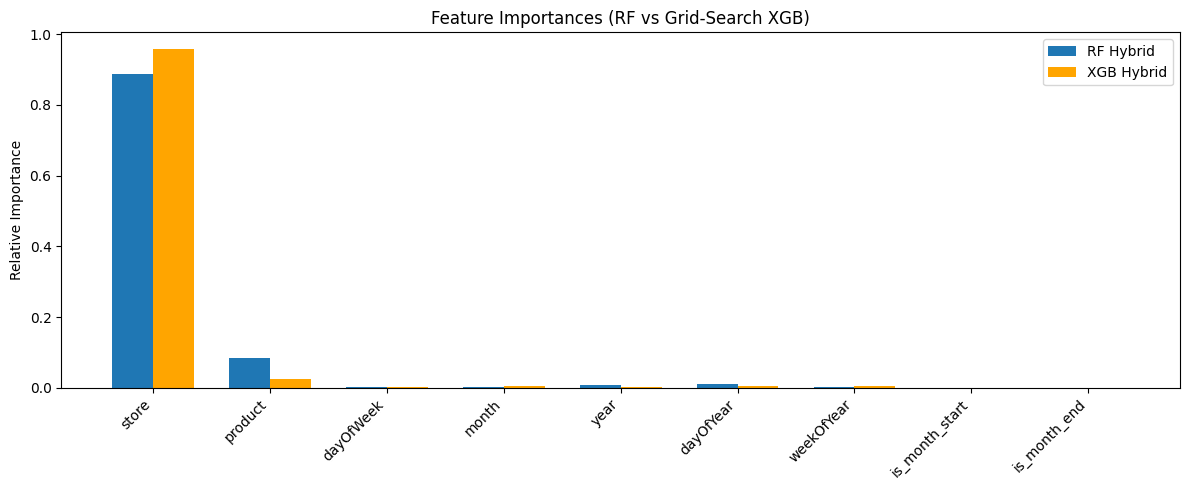

In [0]:
#  Model Evaluation (with MLP)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error
from xgboost import XGBRegressor
from sklearn.neural_network import MLPRegressor

#  fit  “default” XGB:
xgb_default = XGBRegressor(random_state=42, verbosity=0)
xgb_default.fit(X, y)

# rf_final

#  MLP on residuals:
mlp = MLPRegressor(hidden_layer_sizes=(64,32),
                   activation="relu",
                   solver="adam",
                   max_iter=200,
                   random_state=42)
residuals = y - base
mlp.fit(X, residuals)
y_pred_mlp = base + mlp.predict(X)

pred_grid = base + grid_search.best_estimator_.predict(X) 
pred_rf   = base + rf_final.predict(X)                     
pred_xgb  = base + xgb_default.predict(X)                  


metrics_df = pd.DataFrame({
    'Model': ['ARIMA+GridSearch XGB','ARIMA+RF','ARIMA+XGB','ARIMA+MLP'],
    'MAE': [
        mean_absolute_error(y, pred_grid),
        mean_absolute_error(y, pred_rf),
        mean_absolute_error(y, pred_xgb),
        mean_absolute_error(y, y_pred_mlp)
    ],
    'RMSE': [
        mean_squared_error(y, pred_grid, squared=False),
        mean_squared_error(y, pred_rf,   squared=False),
        mean_squared_error(y, pred_xgb,  squared=False),
        mean_squared_error(y, y_pred_mlp, squared=False)
    ]
})
display(metrics_df)

# best by MAE
best_row   = metrics_df.loc[metrics_df['MAE'].idxmin()]
best_model = best_row['Model']
y_pred_best = {
    'ARIMA+GridSearch XGB': pred_grid,
    'ARIMA+RF':             pred_rf,
    'ARIMA+XGB':            pred_xgb,
    'ARIMA+MLP':            y_pred_mlp
}[best_model]

errors = y - y_pred_best
plt.figure(figsize=(6,4))
plt.hist(errors, bins=50)
plt.title(f'Residual Error Distribution ({best_model})')
plt.xlabel('Error')
plt.ylabel('Frequency')
plt.grid(True)
plt.tight_layout()
plt.show()

feat_additional = ['dayOfYear','weekOfYear','is_month_start','is_month_end']
all_features    = FEATURE_COLS + feat_additional

imp_rf  = rf_final.feature_importances_
imp_xgb = grid_search.best_estimator_.feature_importances_

x = np.arange(len(all_features))
w = 0.35

plt.figure(figsize=(12,5))
plt.bar(x - w/2, imp_rf,  w, label='RF Hybrid')
plt.bar(x + w/2, imp_xgb, w, label='XGB Hybrid', color='orange')
plt.xticks(x, all_features, rotation=45, ha='right')
plt.title('Feature Importances (RF vs Grid-Search XGB)')
plt.ylabel('Relative Importance')
plt.legend()
plt.tight_layout()
plt.show()


MLP Hybrid MAE: 10.75, RMSE: 20.60


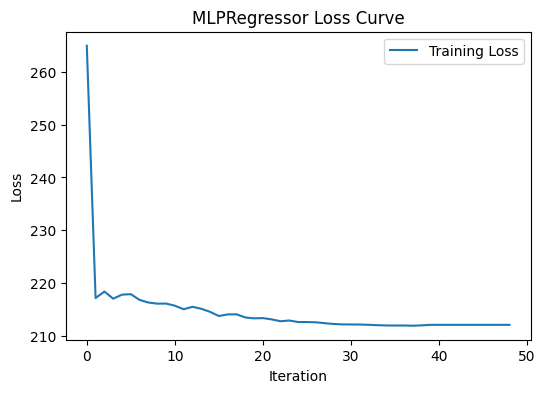

In [0]:
# Deep Learning MLP on the Hybrid Features

from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt

# Prepare data
X_mlp   = hybrid_df[FEATURE_COLS].values
y_mlp   = hybrid_df["number_sold"].values
base_mlp= hybrid_df["baseline"].fillna(0).values

# Define & train MLP on residuals
mlp = MLPRegressor(hidden_layer_sizes=(64,32),
                   activation="relu",
                   solver="adam",
                   max_iter=100,
                   random_state=42)
mlp.fit(X_mlp, y_mlp - base_mlp)

# Predict & recombine
resid_pred = mlp.predict(X_mlp)
hybrid_mlp = base_mlp + resid_pred

# Evaluate
mae_mlp  = mean_absolute_error(y_mlp, hybrid_mlp)
rmse_mlp = mean_squared_error(y_mlp, hybrid_mlp, squared=False)
print(f"MLP Hybrid MAE: {mae_mlp:.2f}, RMSE: {rmse_mlp:.2f}")

# Plot convergence
plt.figure(figsize=(6,4))
plt.plot(mlp.loss_curve_, label="Training Loss")
plt.title("MLPRegressor Loss Curve")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.legend()
plt.show()


In [0]:
#  PRODUCTION-READY MLflow LOGGING & ARTIFACT STORAGE 

import mlflow
import mlflow.sklearn

mlflow.set_tracking_uri("file:///dbfs/mlflow")

experiment_name = "Hybrid_Time_Series_Forecasting"
exp = mlflow.get_experiment_by_name(experiment_name)
if exp is None:
    mlflow.create_experiment(
        name=experiment_name,
        artifact_location="dbfs:/mlflow/Hybrid_Time_Series-Forecasting"
    )
mlflow.set_experiment(experiment_name)

# logs
with mlflow.start_run() as run:

    #  PARAMETERS
    mlflow.log_param("arima_order", "(1,1,1)")
    mlflow.log_param("arima_seasonal_order", "(1,1,1,12)")
    for k,v in gs_params.items():    mlflow.log_param(f"gs_{k}", v)
    for k,v in ho_params.items():    mlflow.log_param(f"ho_{k}", v)

    #  METRICS
    mlflow.log_metric("MAE_GridSearch_XGB", gs_mae)
    mlflow.log_metric("MAE_HyperOpt_XGB", ho_mae)
    mlflow.log_metric("MAE_RF_hybrid", rf_mae_val)
    mlflow.log_metric("RMSE_RF_hybrid", rf_rmse_val)

    #  MODELS
    mlflow.sklearn.log_model(best_xgb, "model_xgb_hybrid")
    mlflow.sklearn.log_model(best_rf,  "model_rf_hybrid")

    #  ARTIFACTS
    mlflow.log_artifact("/dbfs/tmp/mae_comparison.png")
    mlflow.log_artifact("/dbfs/tmp/feature_importance.png")

    print(f"MLflow run completed: {run.info.run_id}")


In [0]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
import pandas as pd


#  Compute the metrics 
mae_mlp   = mean_absolute_error(y, y_pred_mlp)
rmse_mlp  = mean_squared_error(y, y_pred_mlp, squared=False)
mape_mlp  = (np.abs((y - y_pred_mlp) / y).mean()) * 100

#  Build a tiny DataFrame and export it
mlp_results = pd.DataFrame({
    'metric': ['MAE', 'RMSE', 'MAPE'],
    'value':  [mae_mlp, rmse_mlp, mape_mlp]
})




In [0]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col

spark = SparkSession.builder.getOrCreate()

spark_df = spark.createDataFrame(hybrid_df)

mlp_spark_df = (
    spark_df
      .withColumnRenamed("mlp_pred", "predicted_sales")
      .select("Date", "store", "product", "number_sold", "predicted_sales")
)

(
    mlp_spark_df
      .coalesce(1)
      .write
      .mode("overwrite")
      .option("header", True)
      .csv("/FileStore/tables/outputmlp")
)

display(dbutils.fs.ls("dbfs:/FileStore/tables/outputmlp"))


path,name,size,modificationTime
dbfs:/FileStore/tables/outputmlp/_SUCCESS,_SUCCESS,0,1751896236000
dbfs:/FileStore/tables/outputmlp/_committed_1744741230658414908,_committed_1744741230658414908,114,1751896198000
dbfs:/FileStore/tables/outputmlp/_committed_7526851921179653219,_committed_7526851921179653219,214,1751896235000
dbfs:/FileStore/tables/outputmlp/_started_1744741230658414908,_started_1744741230658414908,0,1751896197000
dbfs:/FileStore/tables/outputmlp/_started_7526851921179653219,_started_7526851921179653219,0,1751896235000
dbfs:/FileStore/tables/outputmlp/part-00000-tid-7526851921179653219-8c287bb2-198d-4e18-88d9-c4205cfdaad7-1019-1-c000.csv,part-00000-tid-7526851921179653219-8c287bb2-198d-4e18-88d9-c4205cfdaad7-1019-1-c000.csv,11752860,1751896235000
